In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

idx = pd.IndexSlice

DATA_DIR = Path("data/random_search")

In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

In [5]:
def get_random_search_traces():
    paths = list(DATA_DIR.rglob("*.json"))

    scenarios = []
    for file_path in tqdm(paths):
        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))

        match file_path.parts:
            case (_, _, repetition, it, fid, _):
                # print(f"{rep =} {it= } {fid=}")
                scenario_data["repetition"] = int(repetition)
                scenario_data["iteration"] = int(it)

                _, dr, _, dt = fid.split("_")
                scenario_data["decision_repeat"] = int(dr)
                scenario_data["dt"] = float(dt)

            case _:
                raise ValueError("Can't parse path!")

        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [6]:
df = get_random_search_traces()

100%|██████████| 2173/2173 [00:06<00:00, 329.79it/s]


In [7]:
df = df.set_index(
    ["decision_repeat", "dt", "repetition", "iteration"],
)
df = df[~df.index.duplicated(keep="first")]
df = df.sort_index()
df

start_ts  initialized_ts  \
decision_repeat dt   repetition iteration                                  
5               0.02 0          0           84847.778848    84848.287701   
                                1           84908.850104    84909.394391   
                                2           84968.489731    84968.965881   
                                3           85040.087931    85040.505547   
                                4           85109.373908    85109.839067   
...                                                  ...             ...   
20              0.04 4          15         121591.190175   121591.509740   
                                16         121600.239485   121600.883173   
                                17         121627.304934   121627.757978   
                                18         121657.628157   121658.213882   
                                19         121684.626022   121685.088340   

                                           scenario_done_ts  init_time  \
decision_repeat dt   repetition iteration                                
5               0.02 0          0              84908.298831   0.508852   
                                1              84967.954766   0.544287   
                                2              85039.513441   0.476150   
                                3              85108.831804   0.417616   
                                4              85163.665898   0.465158   
...                                                     ...        ...   
20              0.04 4          15            121599.263517   0.319565   
                                16            121626.235011   0.643688   
                                17            121656.567949   0.453044   
                                18            121683.540791   0.585725   
                                19            121688.407280   0.462318   

                                           scenario_time  total_time  \
decision_repeat dt   repetition iteration                              
5               0.02 0          0              60.011130   60.519983   
                                1              58.560375   59.104663   
                                2              70.547560   71.023710   
                                3              68.326257   68.743873   
                                4              53.826831   54.291989   
...                                                  ...         ...   
20              0.04 4          15              7.753778    8.073342   
                                16             25.351838   25.995526   
                                17             28.809971   29.263015   
                                18             25.326908   25.912633   
                                19              3.318940    3.781259   

                                           n_crashed_vehicles  \
decision_repeat dt   repetition iteration                       
5               0.02 0          0                           0   
                                1                           0   
                                2                           0   
                                3                           1   
                                4                           0   
...                                                       ...   
20              0.04 4          15                          0   
                                16                          0   
                                17                          1   
                                18                          0   
                                19                          0   

                                                                                    map_data  \
decision_repeat dt   repetition iteration                                                      
5               0.02 0          0          [{'id': 'I', 'pre_block_socket_index': None}, ...   
                         

In [8]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error


def calculate_driving_score(df):
    df["driving_score"] = (
        df["route_completion"]
        * df["in_road_percentage"]
        * (0.65) ** df["n_sidewalk_crashes"]
        * (0.60) ** df["n_crashed_vehicles"]
    )
    return df


df = calculate_driving_score(df)

In [9]:
def get_solutions_of_iteration(curr_it, df):

    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it]]

    # get index of minumum driving score -> solution
    solutions_idx = (
        slice.groupby(
            [
                "decision_repeat",
                "dt",
                "repetition",
            ]
        )["driving_score"]
        .idxmin()
        .rename("solution_idx")
    ).to_frame()

    solutions_idx["iteration"] = curr_it
    solutions_idx = solutions_idx.reset_index().set_index(
        ["decision_repeat", "dt", "repetition", "iteration"]
    )

    return solutions_idx

In [10]:
iterations = df.index.get_level_values("iteration").unique()
iterations

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55],
      dtype='int64', name='iteration')

In [11]:
sols_df = pd.concat([get_solutions_of_iteration(it, df) for it in iterations], axis=0)
sols_df = sols_df.sort_index()
sols_index = pd.MultiIndex.from_tuples(sols_df["solution_idx"])

In [12]:
df = df[["total_time", "driving_score", "seed"]]
sols_df = df.loc[sols_index]
sols_df

total_time  driving_score  \
decision_repeat dt   repetition iteration                              
5               0.02 0          0           60.519983       0.991255   
                                0           60.519983       0.991255   
                                0           60.519983       0.991255   
                                3           68.743873       0.596023   
                                3           68.743873       0.596023   
...                                               ...            ...   
20              0.04 4          0            6.455816       0.067272   
                                0            6.455816       0.067272   
                                0            6.455816       0.067272   
                                0            6.455816       0.067272   
                                0            6.455816       0.067272   

                                                 seed  
decision_repeat dt   repetition iteration              
5               0.02 0          0          6750770235  
                                0          6750770235  
                                0          6750770235  
                                3          6019026122  
                                3          6019026122  
...                                               ...  
20              0.04 4          0          4976708462  
                                0          4976708462  
                                0          4976708462  
                                0          4976708462  
                                0          4976708462  

[3360 rows x 3 columns]

In [13]:
sols_df = sols_df.reset_index()
sols_df = sols_df.rename(
    columns={"iteration": "solutions_iteration", "driving_score": "solution_dscore"}
)
sols_df["iteration"] = sols_df.groupby(
    ["decision_repeat", "dt", "repetition"]
).cumcount()

sols_df = sols_df.set_index(["decision_repeat", "dt", "repetition", "iteration"])

In [14]:
sols_df
# insert verified driving score here

solutions_iteration  total_time  \
decision_repeat dt   repetition iteration                                    
5               0.02 0          0                            0   60.519983   
                                1                            0   60.519983   
                                2                            0   60.519983   
                                3                            3   68.743873   
                                4                            3   68.743873   
...                                                        ...         ...   
20              0.04 4          51                           0    6.455816   
                                52                           0    6.455816   
                                53                           0    6.455816   
                                54                           0    6.455816   
                                55                           0    6.455816   

                                           solution_dscore        seed  
decision_repeat dt   repetition iteration                               
5               0.02 0          0                 0.991255  6750770235  
                                1                 0.991255  6750770235  
                                2                 0.991255  6750770235  
                                3                 0.596023  6019026122  
                                4                 0.596023  6019026122  
...                                                    ...         ...  
20              0.04 4          51                0.067272  4976708462  
                                52                0.067272  4976708462  
                                53                0.067272  4976708462  
                                54                0.067272  4976708462  
                                55                0.067272  4976708462  

[3360 rows x 4 columns]

In [15]:
data = sols_df.groupby(["decision_repeat", "dt", "iteration"]).mean()

# data = sols_df.xs(0, level="repetition")
data

solutions_iteration  total_time  \
decision_repeat dt   iteration                                    
5               0.02 0                          0.0   62.873654   
                     1                          0.4   65.415572   
                     2                          0.6   64.179402   
                     3                          1.4   66.941809   
                     4                          1.6   94.770270   
...                                             ...         ...   
20              0.04 51                        16.2    7.563060   
                     52                        16.2    7.563060   
                     53                        16.2    7.563060   
                     54                        16.2    7.563060   
                     55                        16.2    7.563060   

                                solution_dscore          seed  
decision_repeat dt   iteration                                 
5               0.02 0                 0.785616  5.529844e+09  
                     1                 0.579292  4.907122e+09  
                     2                 0.579256  4.201422e+09  
                     3                 0.500012  4.044403e+09  
                     4                 0.448245  3.550648e+09  
...                                         ...           ...  
20              0.04 51                0.032689  5.216641e+09  
                     52                0.032689  5.216641e+09  
                     53                0.032689  5.216641e+09  
                     54                0.032689  5.216641e+09  
                     55                0.032689  5.216641e+09  

[672 rows x 4 columns]

<Axes: xlabel='iteration', ylabel='solution_dscore'>

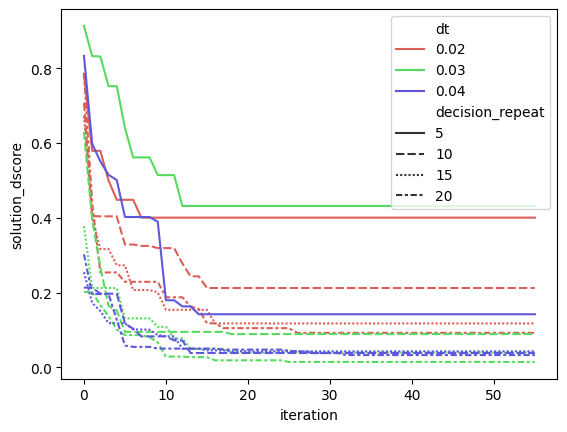

In [16]:
palette = sns.color_palette("hls", 3)
sns.lineplot(
    data,
    x="iteration",
    y="solution_dscore",
    style="decision_repeat",
    hue="dt",
    palette=palette,
)